In [13]:
import pandas as pd
import configs_py3 as configs
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import utilities as utils
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch
import os
import skimage.io as io

In [21]:
def get_val_set_labelled():
    
    model = ViltForQuestionAnswering.from_pretrained(configs.CHECKPOINT)
    processor = ViltProcessor.from_pretrained(configs.CHECKPOINT)

    df, train_df, val_df, test_df = utils.load_dataset()

    original_model_outputs = []
 
    softmax_outputs = []
    isRandom_Question = []
    
    for index, row in val_df.head(int(len(val_df)/2)).iterrows():
        imgId = row['image_id']
        imgFilename = 'COCO_' + configs.dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
        imgPath = configs.imgDir + imgFilename
        
        if not os.path.isfile(imgPath):
            continue
        
            
        image = Image.open(imgPath)
        text = row['original_question']
        isRandom_Question.append(0)
        # prepare inputs
        try:
            inputs = processor(image, text, return_tensors="pt")
        except Exception as e:
            I = io.imread(imgPath)
        
            plt.imshow(I)
            plt.axis('off')
            plt.show()
            print(e, "==> Skipping this image")
          
            original_model_outputs.append("N/A")
            softmax_outputs.append("N/A")
            continue                
        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        
        softmax_output = torch.nn.functional.softmax(outputs.logits, dim=1)
        softmax_output = softmax_output[0, idx].item()
        softmax_outputs.append(softmax_output)
        
        original_model_outputs.append(model.config.id2label[idx])
        
        
        
        
    
    for index, row in val_df.tail(len(val_df) - int(len(val_df)/2)).iterrows():
        imgId = row['image_id']
        imgFilename = 'COCO_' + configs.dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
        imgPath = configs.imgDir + imgFilename
        
        if not os.path.isfile(imgPath):
            continue
        
            
        image = Image.open(imgPath)
        text = row['random_question']
        isRandom_Question.append(1)
        # prepare inputs
        try:
            inputs = processor(image, text, return_tensors="pt")
        except Exception as e:
            I = io.imread(imgPath)
        
            plt.imshow(I)
            plt.axis('off')
            plt.show()
            print(e, "==> Skipping this image")
          
            original_model_outputs.append("N/A")
            softmax_outputs.append("N/A")
            continue                
        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        
        softmax_output = torch.nn.functional.softmax(outputs.logits, dim=1)
        softmax_output = softmax_output[0, idx].item()
        softmax_outputs.append(softmax_output)
        
        original_model_outputs.append(model.config.id2label[idx])
        
        
        
    
    val_df[f'original_model_outputs'] = original_model_outputs
    val_df['softmax_outputs'] = softmax_outputs
    
    val_df['isRandomQuestion'] = isRandom_Question
    
    return val_df

In [22]:
val_df =  get_val_set_labelled()

In [ ]:
X = val_df.softmax_outputs
Y = val_df.isRandomQuestion

In [17]:
class BinaryClassification(torch.nn.Module):
    def __init__(self, input_dimension):
            super().__init__()
            self.linear = torch.nn.Linear(input_dimension, 1)
    def forward(self, input_dimension):
            return self.linear(input_dimension)

_, input_dimension = X.shape
model = BinaryClassification(input_dimension)

NameError: name 'X' is not defined

In [93]:
abstain_ratio_dict = {}
for threshold in np.arange(0.1, 1.0, 0.1):

    thresholded_model_outputs = get_thresholded_output(original_model_outputs, softmax_outputs, threshold=threshold)
   
    val_df[f'thresholded_model_outputs_{threshold}'] = thresholded_model_outputs
   
    abstain_ratio_dict[threshold] = len(val_df[val_df[f'thresholded_model_outputs_{threshold}'] == "ABSTAIN"]) / len(val_df)
    print(f"Abstain ratio for threshold {threshold} is {abstain_ratio_dict[threshold]}")
val_df.to_csv(configs.output_path, index=False)

Abstain ratio for threshold 0.1 is 0.032
Abstain ratio for threshold 0.2 is 0.151
Abstain ratio for threshold 0.30000000000000004 is 0.298
Abstain ratio for threshold 0.4 is 0.422
Abstain ratio for threshold 0.5 is 0.544
Abstain ratio for threshold 0.6 is 0.644
Abstain ratio for threshold 0.7000000000000001 is 0.722
Abstain ratio for threshold 0.8 is 0.802
Abstain ratio for threshold 0.9 is 0.87


In [96]:
list(abstain_ratio_dict.keys())

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]

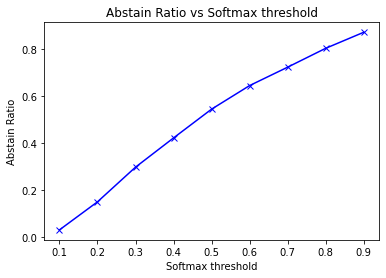

In [107]:
threshold_vals = list(abstain_ratio_dict.keys())
abstain_ratio_vals = list(abstain_ratio_dict.values())
plt.plot(threshold_vals, abstain_ratio_vals, 'b-x')
plt.xlabel("Softmax threshold")
plt.ylabel("Abstain Ratio")
plt.title("Abstain Ratio vs Softmax threshold")
plt.show()